# Optimization
***
## Reference layer with simple sample

First import the necessary packages to describe a sample and perform optimization.

In [1]:
%matplotlib inline

from refnx.reflect import SLD
from refnx.analysis import Parameter
from hogben.models.samples import Sample
from hogben.optimise import optimise_parameters

We need to define a structure to optimize, we do this using the `refnx` module.
In this example, we're creating a structure consisting of a reference layer with three simple layers on top.
We try to figure out what the best reference layer would be for this structure.

In [8]:
def simple_sample():
    """Define a bilayer sample, and return the associated refnx model"""
    
    # Define the fitting parameters for the sample:
    layer1_thick = Parameter(80, 'Layer 1 Thickness', (50, 120))
    layer2_thick = Parameter(40, 'Layer 2 Thickness', (30, 50))
    layer3_thick = Parameter(60, 'Layer 3 Thickness', (50, 120))    
    layer1_rough = Parameter(4, 'Layer 1 Roughness', (2, 10))
    layer2_rough = Parameter(5, 'Layer 2 Roughness', (2, 10))
    layer3_rough = Parameter(3, 'Layer 3 Roughness', (50, 120))
    
    # Define the parameters for the reference layer that we want to optimize
    ref_thick = Parameter(50, 'Reference layer Thickness', (0, 400))
    ref_sld = Parameter(3, 'Reference layer SLD', (-1.9, 9.4))
    ref_msld = Parameter(3, 'Reference layer Magnetic SLD', (0, 7))

    # Tell HOGBEN that these parameters should be optimized
    ref_thick.optimize = True
    ref_sld.optimize = True
    
    # Construct the layers
    air = SLD(0, name='Air')
    D2O = SLD(8, name='D2O')
    layer1 = SLD(6.5, name="Layer 1")(thick=layer1_thick, rough=0)
    layer2 = SLD(1.5, name="Layer 2")(thick=layer2_thick, rough=0)
    layer3 = SLD(4.5, name="Layer 3")(thick=layer3_thick, rough=0)   
    ref_layer_m = MagneticSLD(ref_sld, ref_msld, name="Layer 3")(thick=ref_thick, rough=0)

    substrate = SLD(2.074, name='Substrate')(rough=0)

    # Put all fitting parameters in a list
    params = [
        layer1_rough,
        layer2_rough,
        layer3_rough,
        layer1_thick,
        layer2_thick,
        layer3_thick,
    ]
    
    # Set all fitting parameters to be varying
    for param in params:
        param.vary = True
    
    # Create a structure, separating each layer with a `|`
    sample = substrate | ref_layer_m | layer1 | layer2 | layer3 | air
    sample2 = substrate | ref_layer_m | layer1 | layer2 | layer3 | D2O
    return [sample, sample2]

Now we have defined a structure, but we still need to put this into a HOGBEN sample using the `Sample` class.

In [11]:
structure = simple_sample()
sample = Sample(structure, polarised=True)

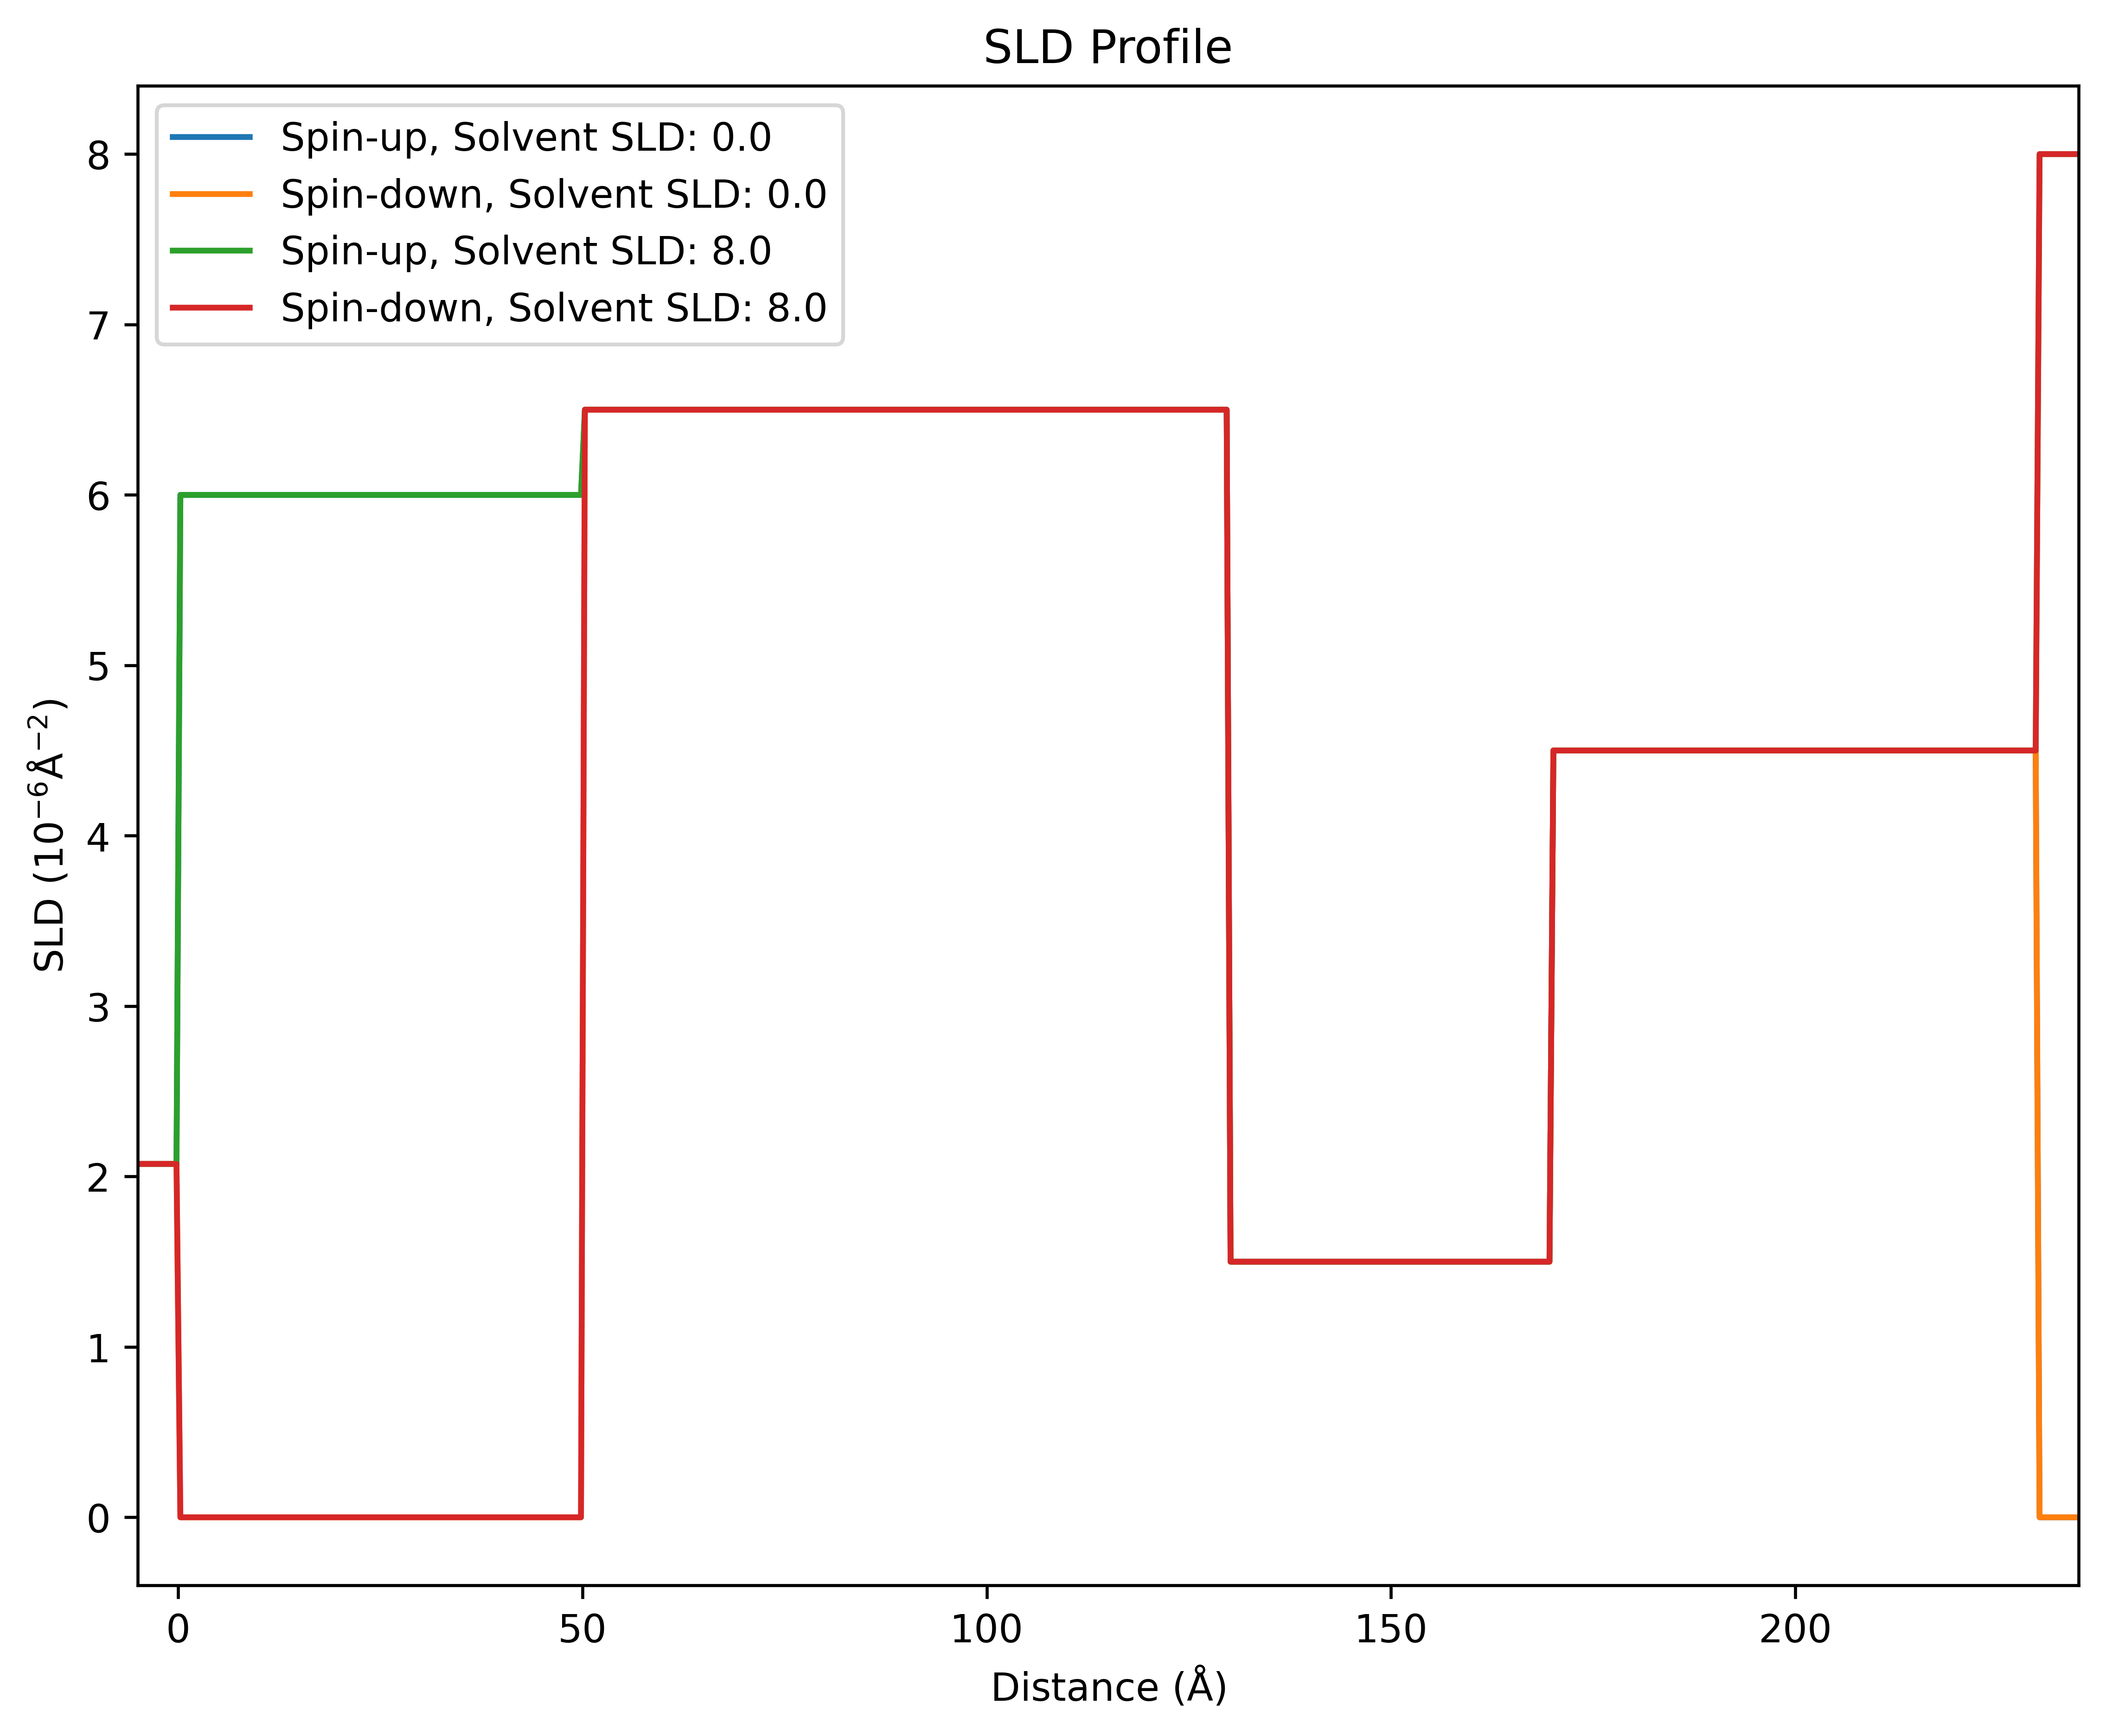

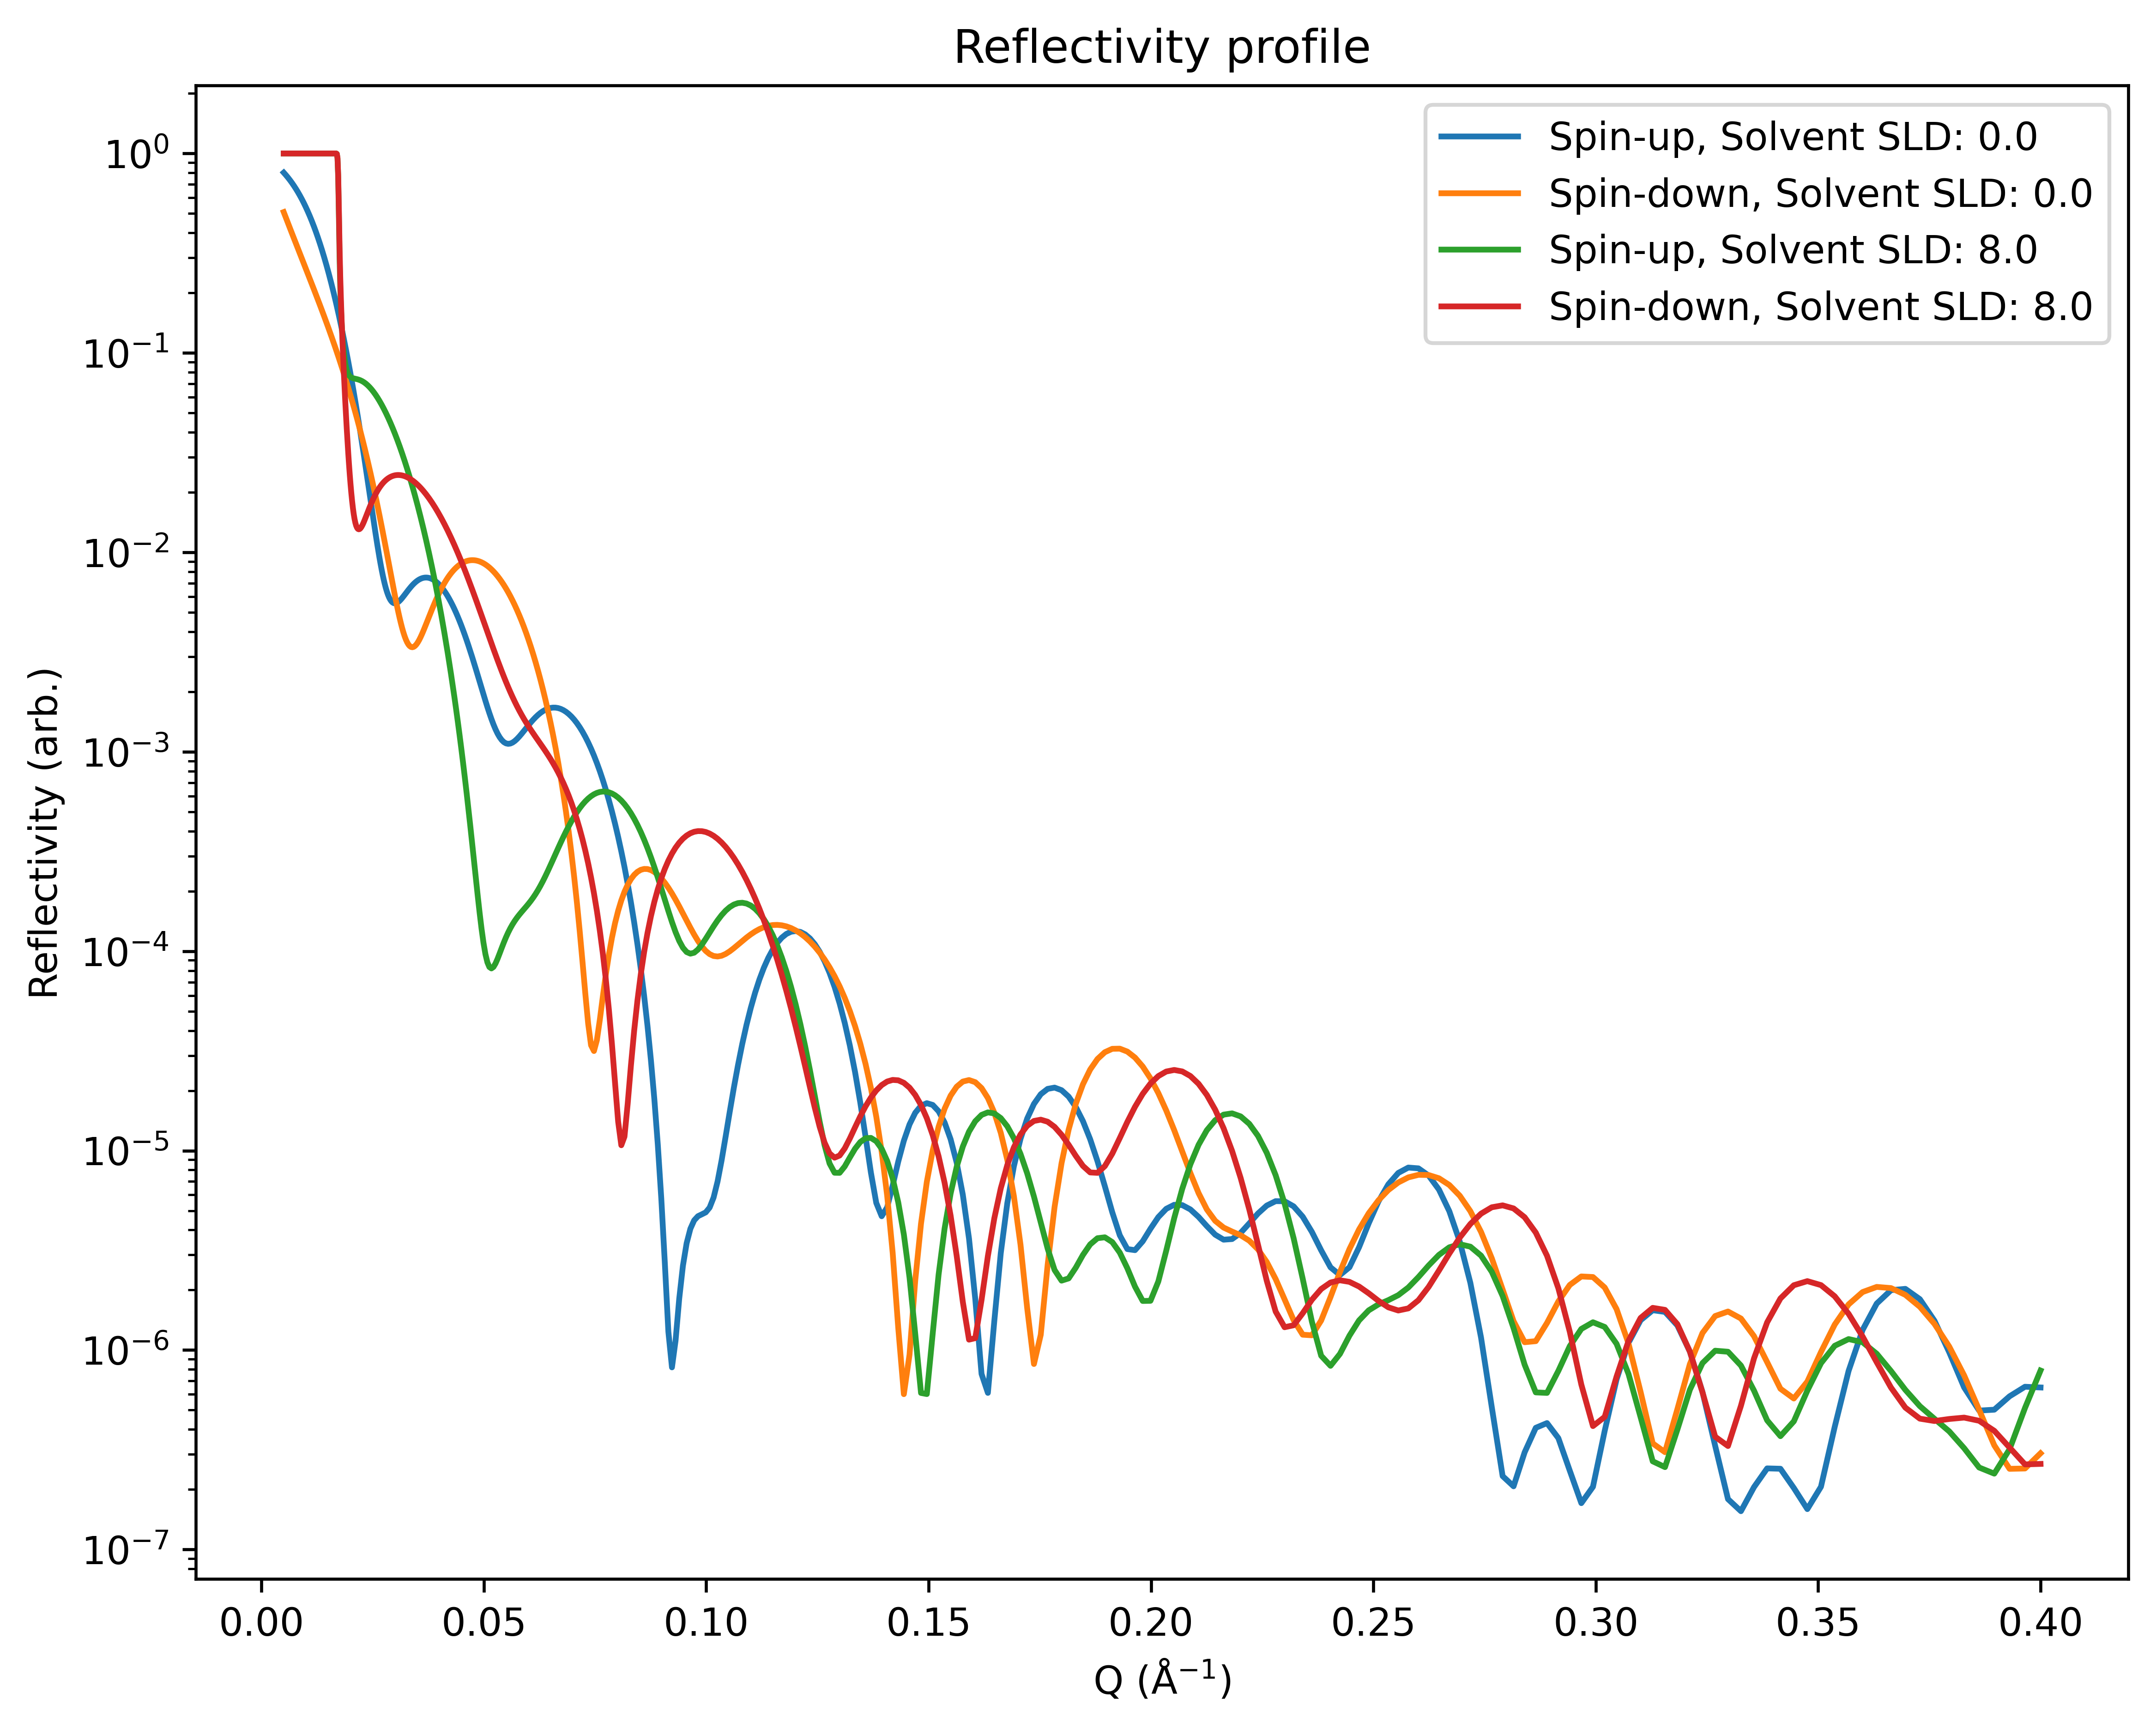

In [12]:
sample.sld_profile()
sample.reflectivity_profile()

Now we simple need define at what angles we measure, how long we measure, and how many data points we obtain at each angle.

This is defined in a list for each angle, like `angle_times = [(angle, data_points, time), (angle2, data_points2, time2)]`

In [11]:
angle_times = [(0.7, 100, 100),
               (2.3, 100, 400),
               ]    

Now simply tell HOGBEN we want to optimize the parameters, we do this using `optimize_parameters`, giving the previously defined HOGBEN sample, and list of `angle_times` as input arguments:

The parameters with the highest information could be found at:
Reference layer Thickness: 19.2
Reference layer SLD: 9.4
-----------------------------------------------------------------
The minimum eigenvalue of the Fisher Information before optimization is 0.0489
After the optimization, the minimum eigenvalue of the Fisher Information is 0.0608
The information content is thus 1.24 times as large after optimization.


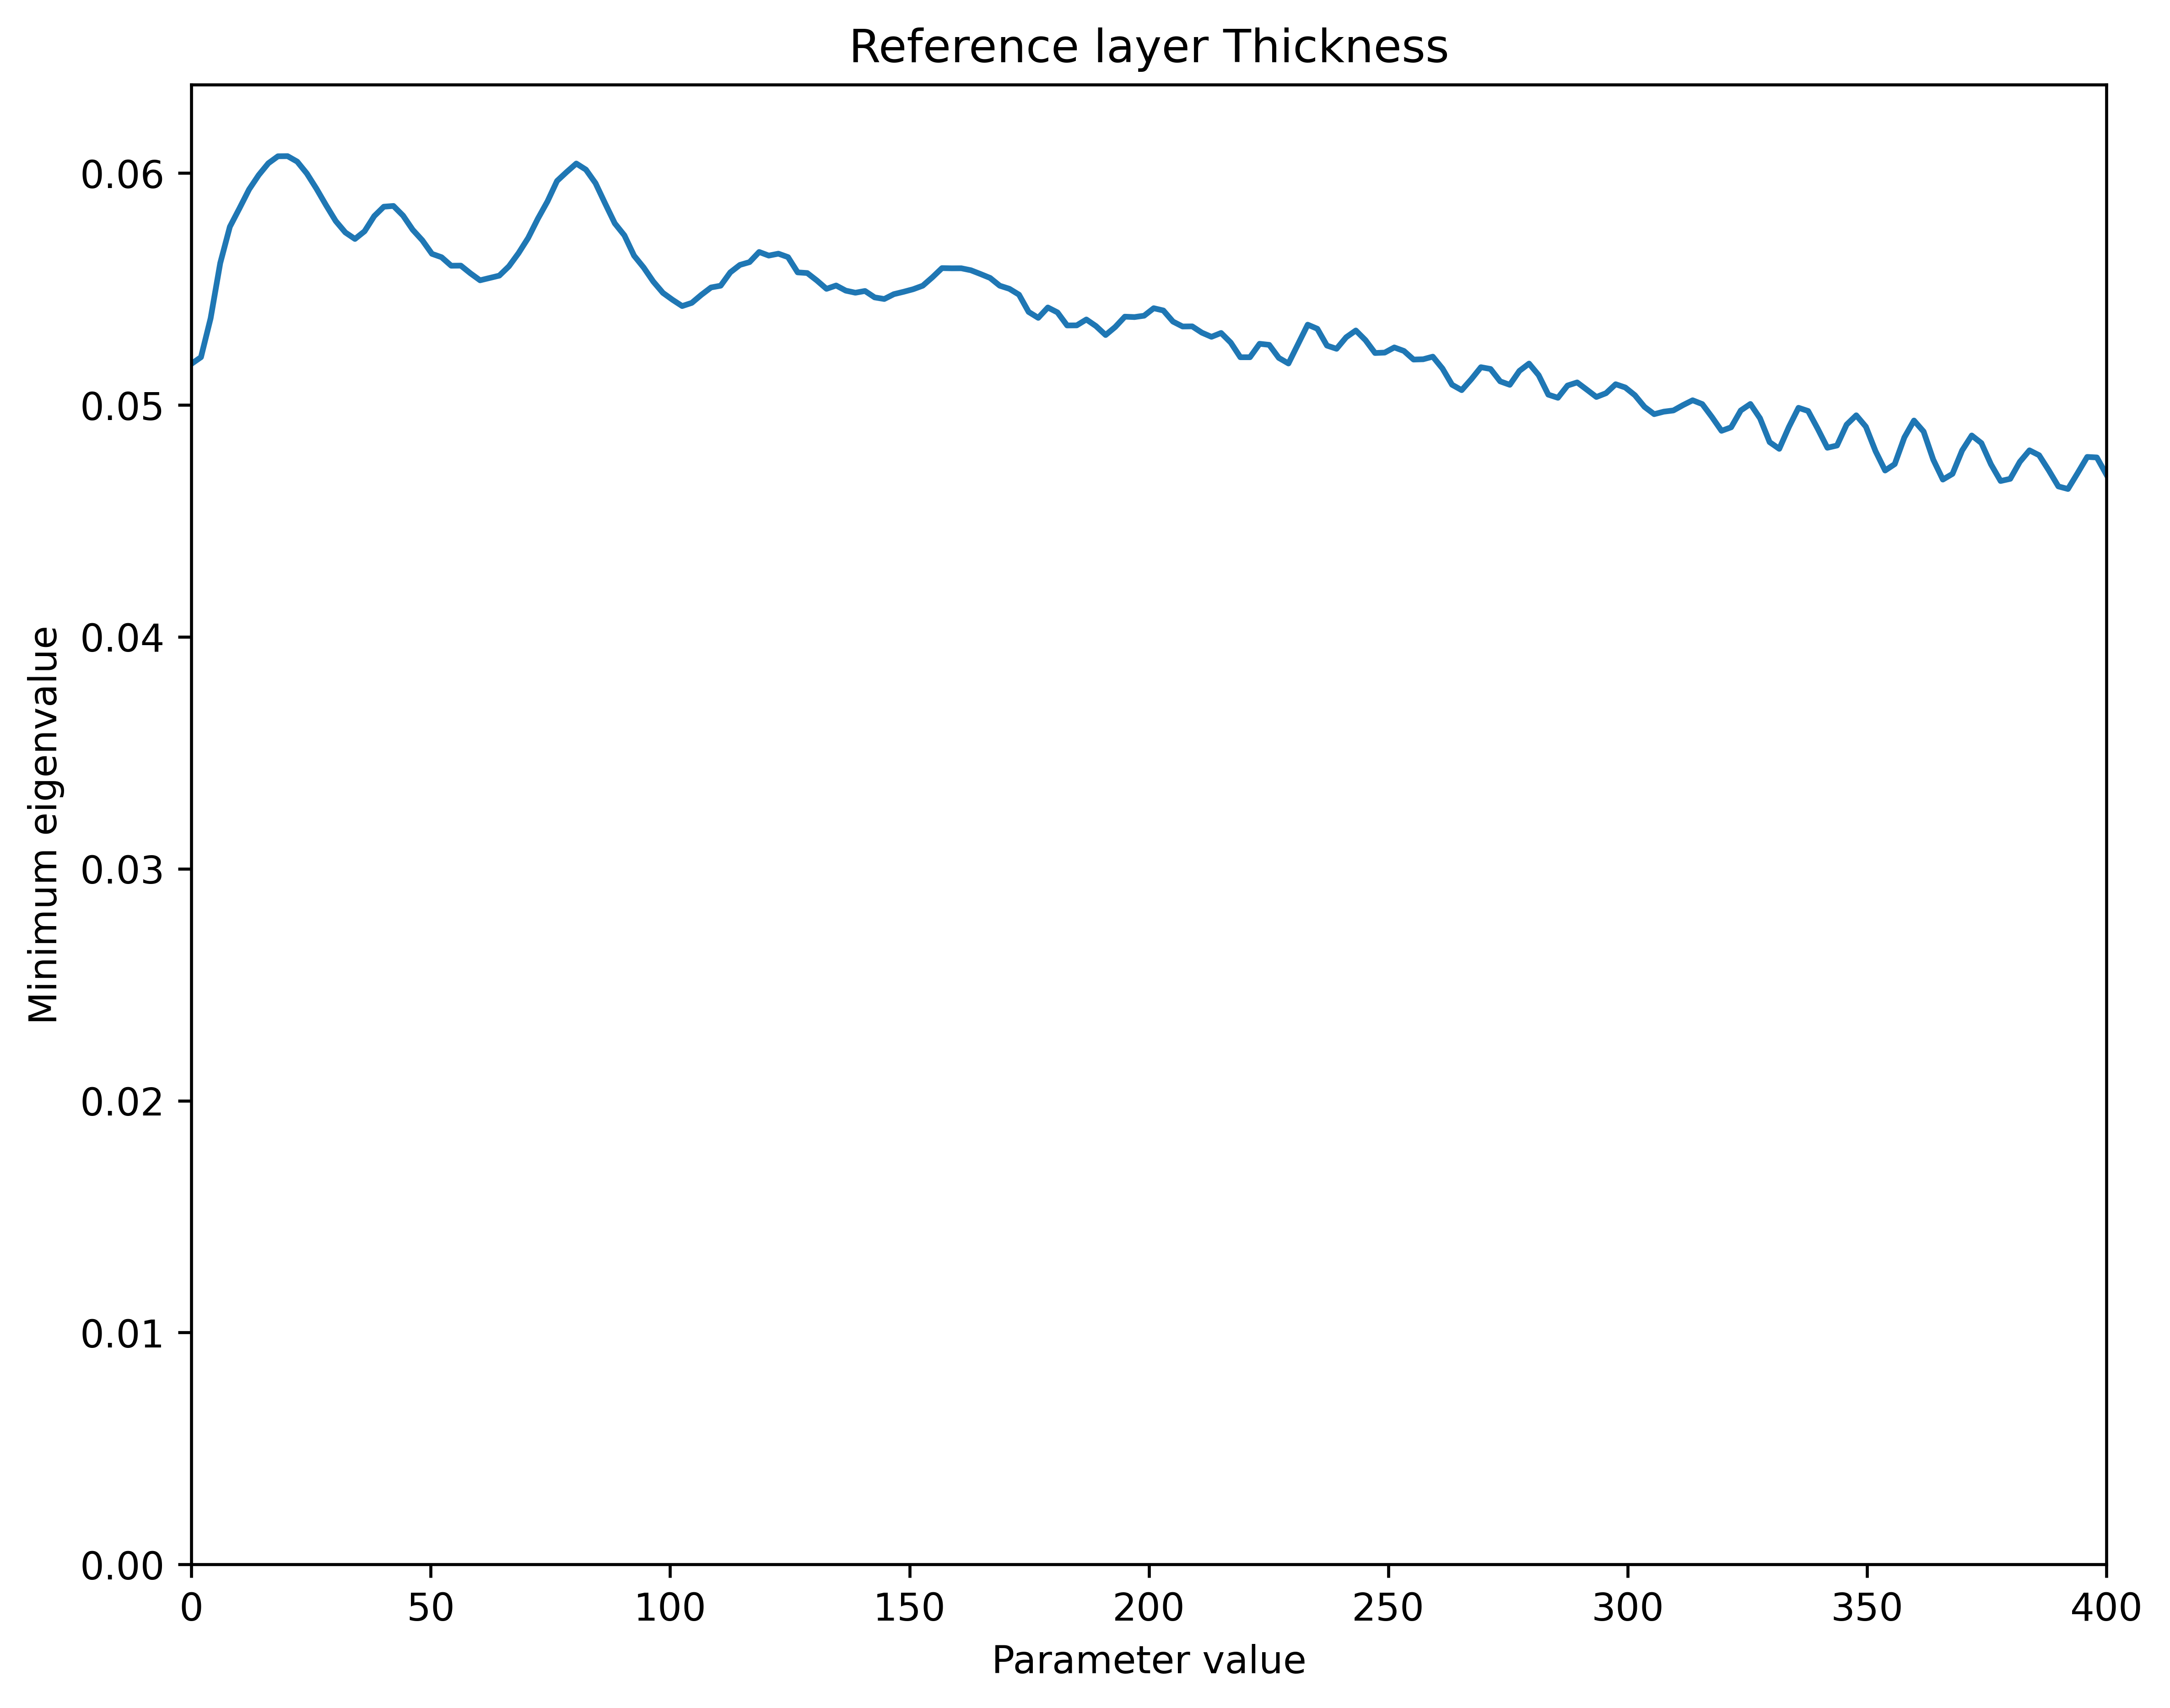

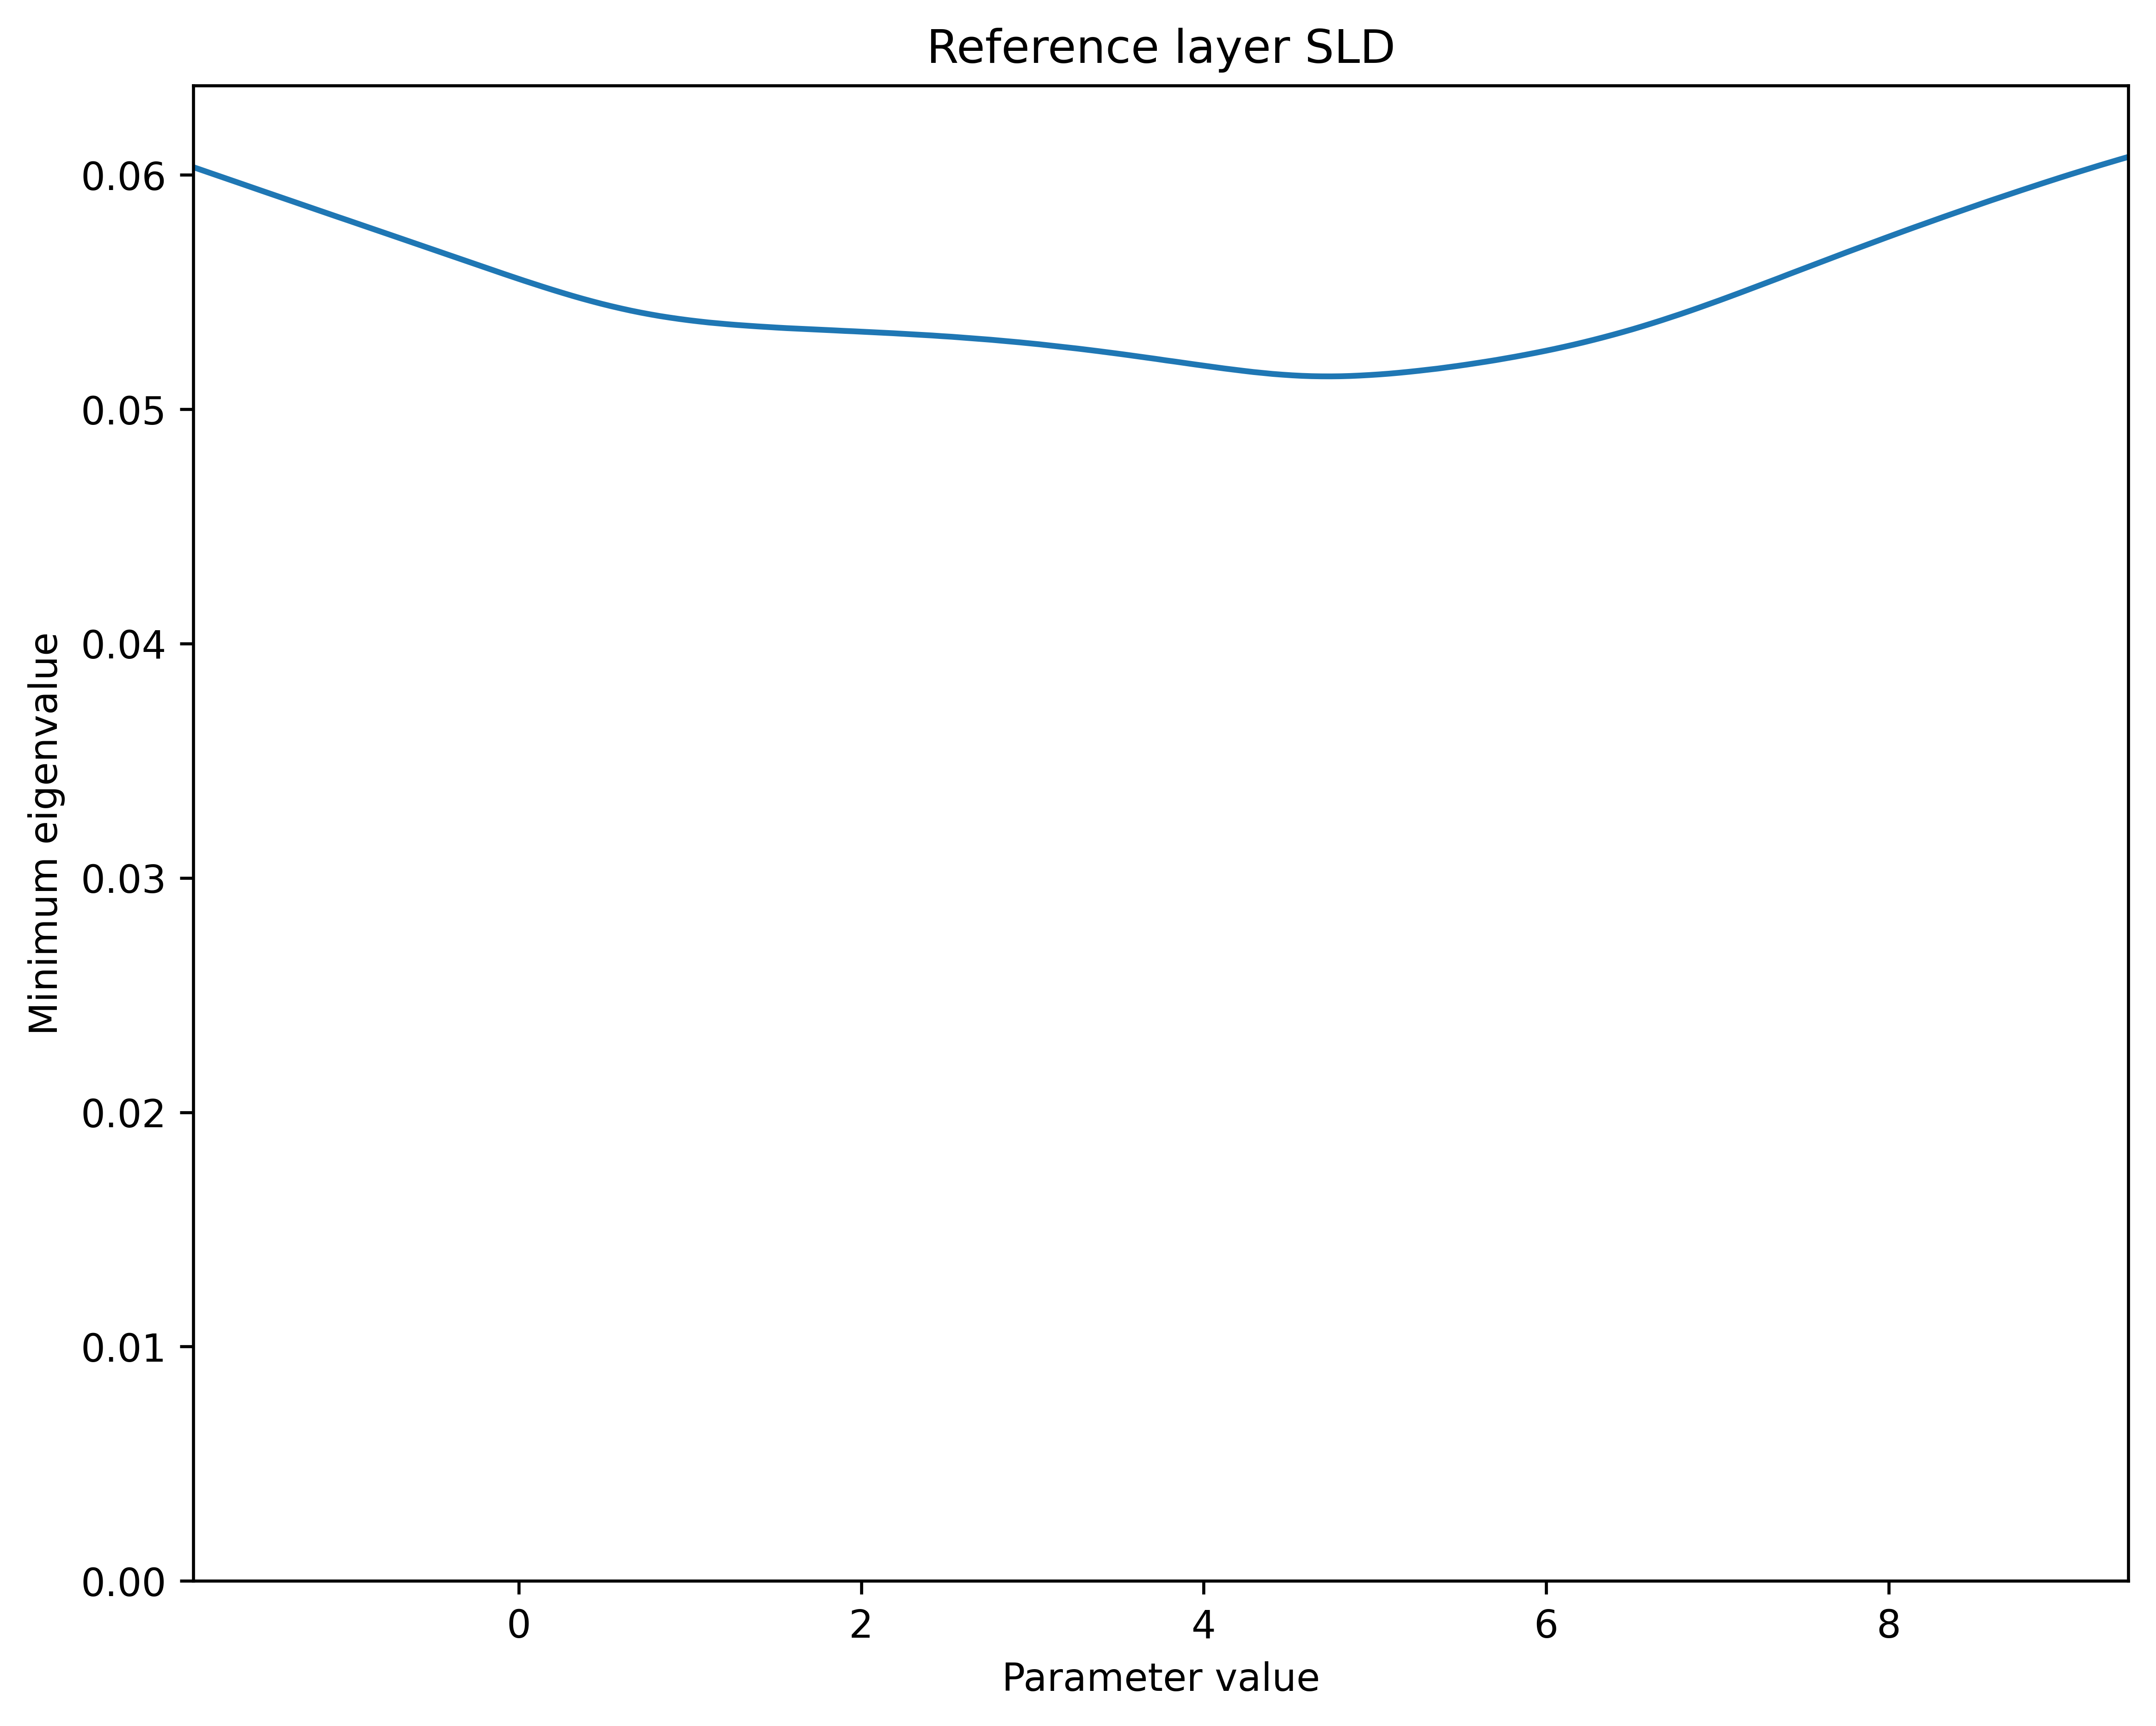

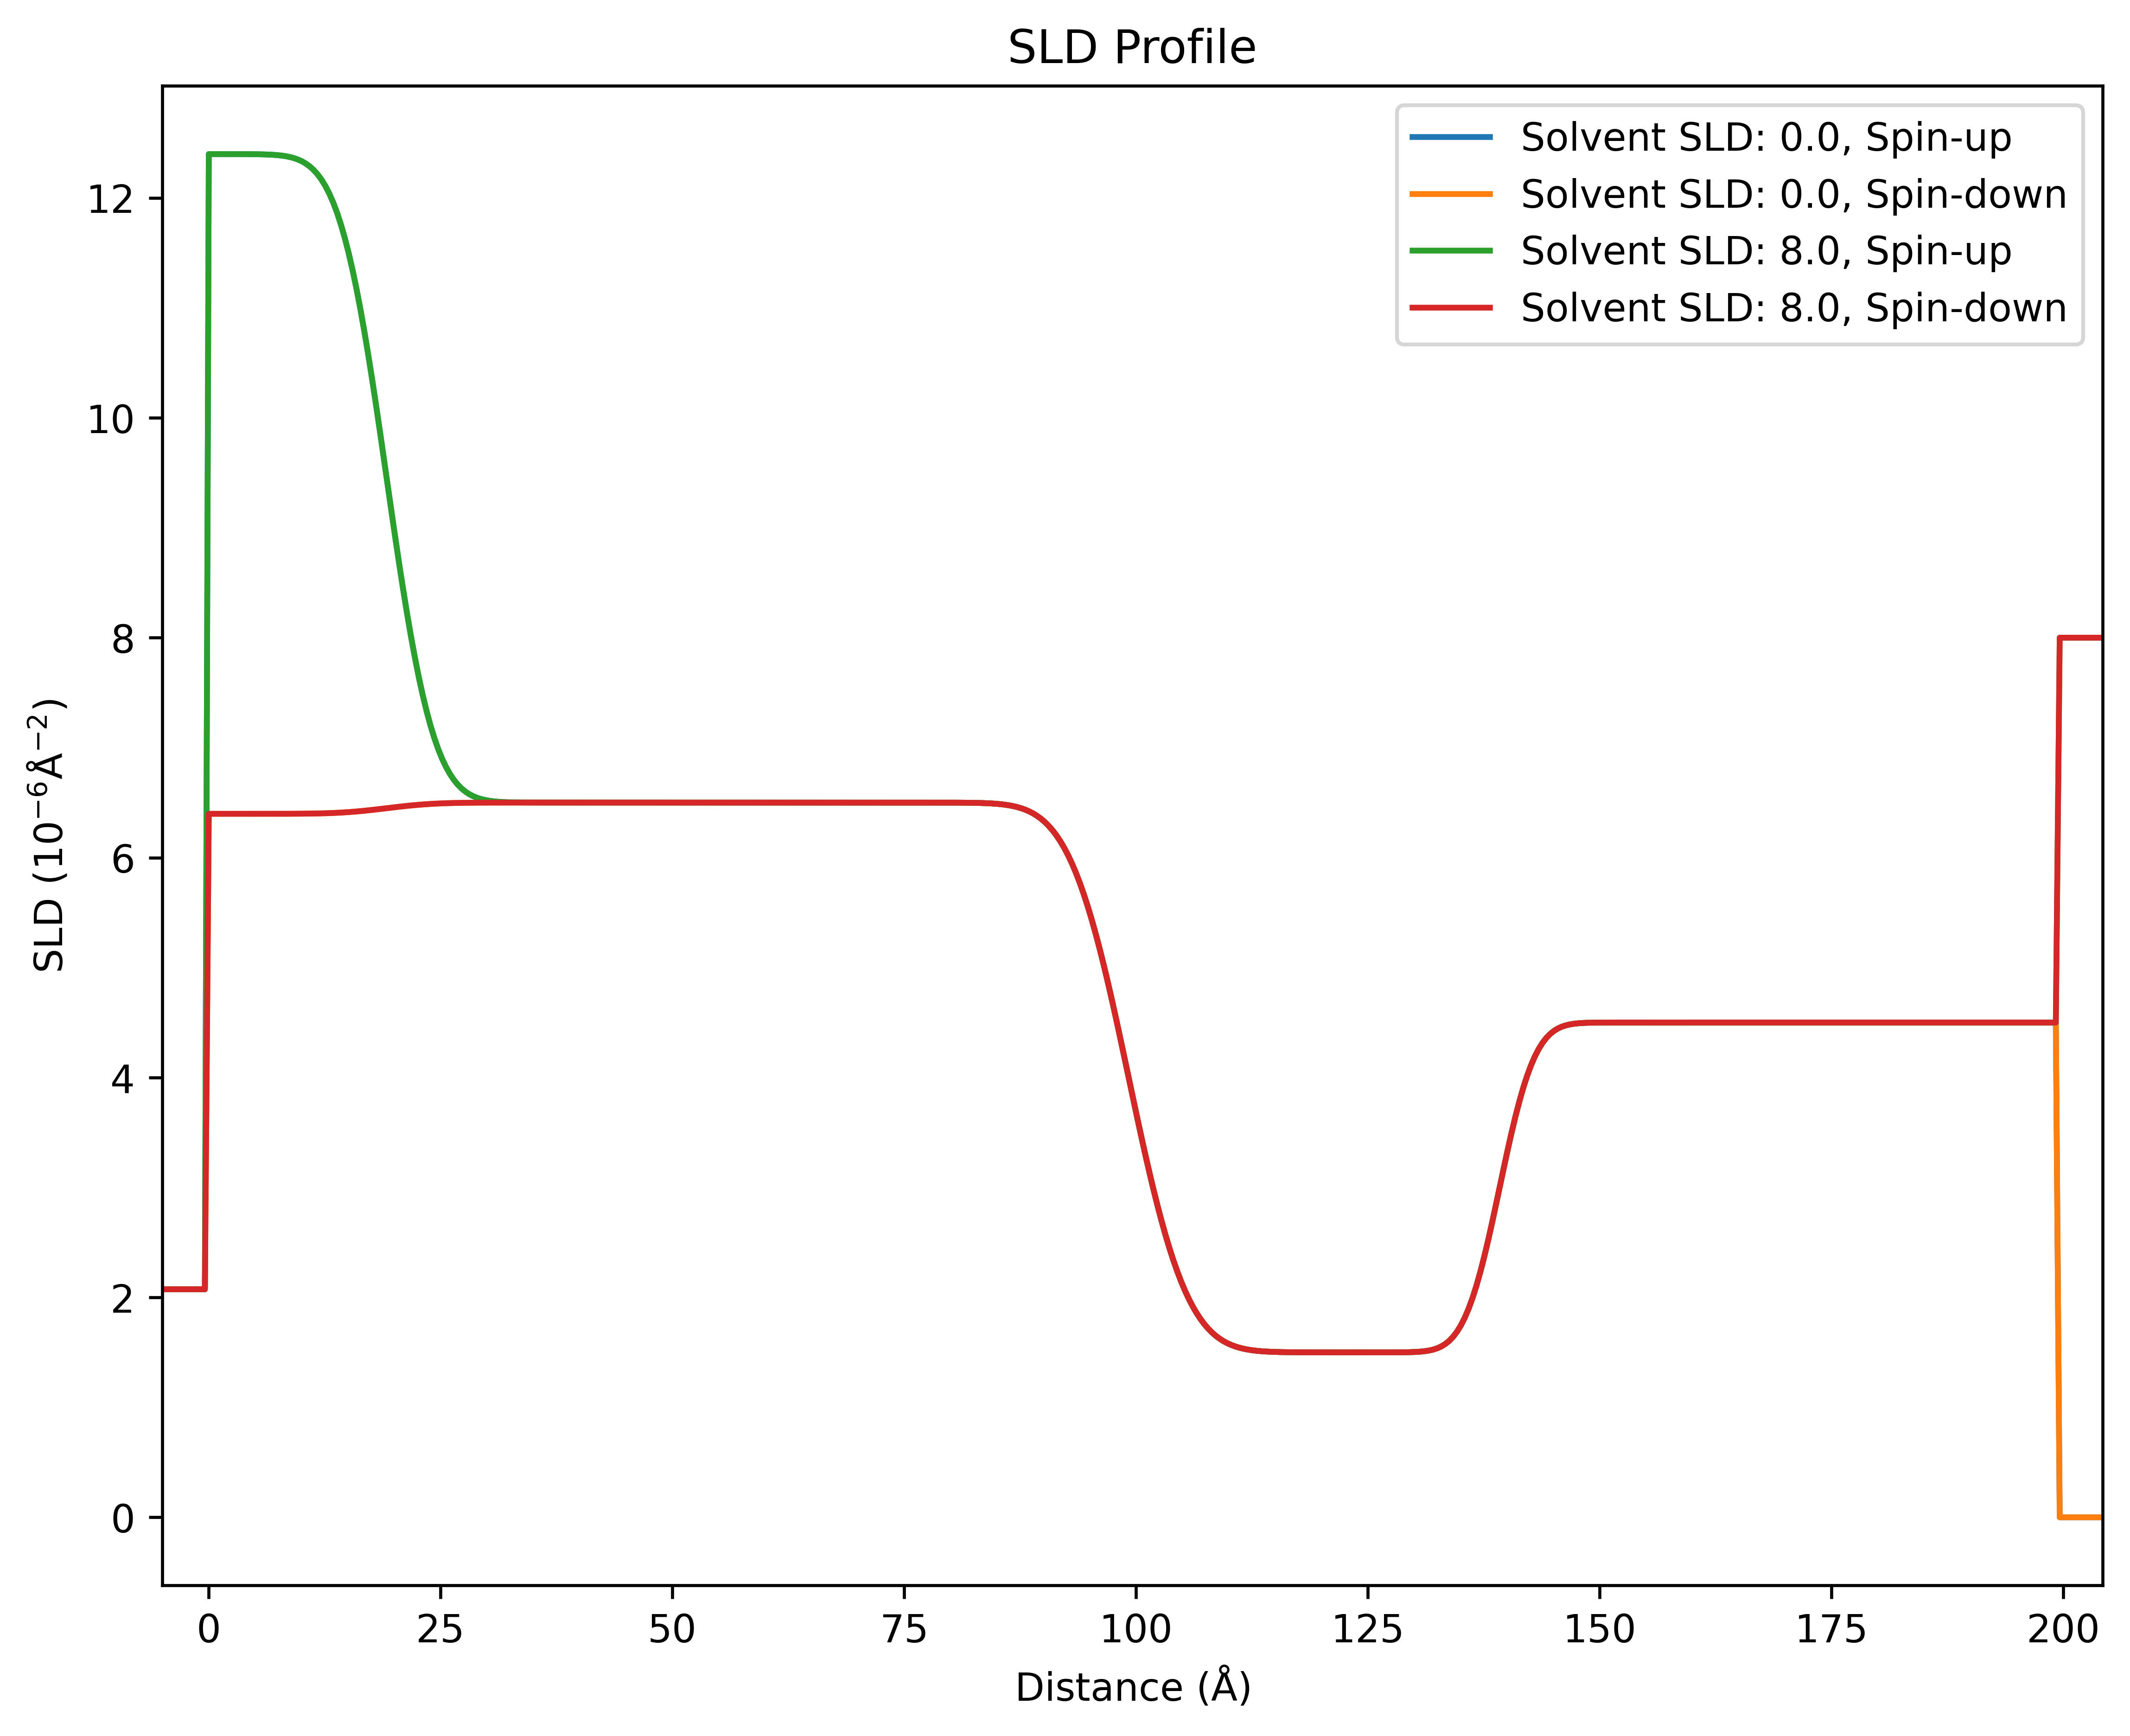

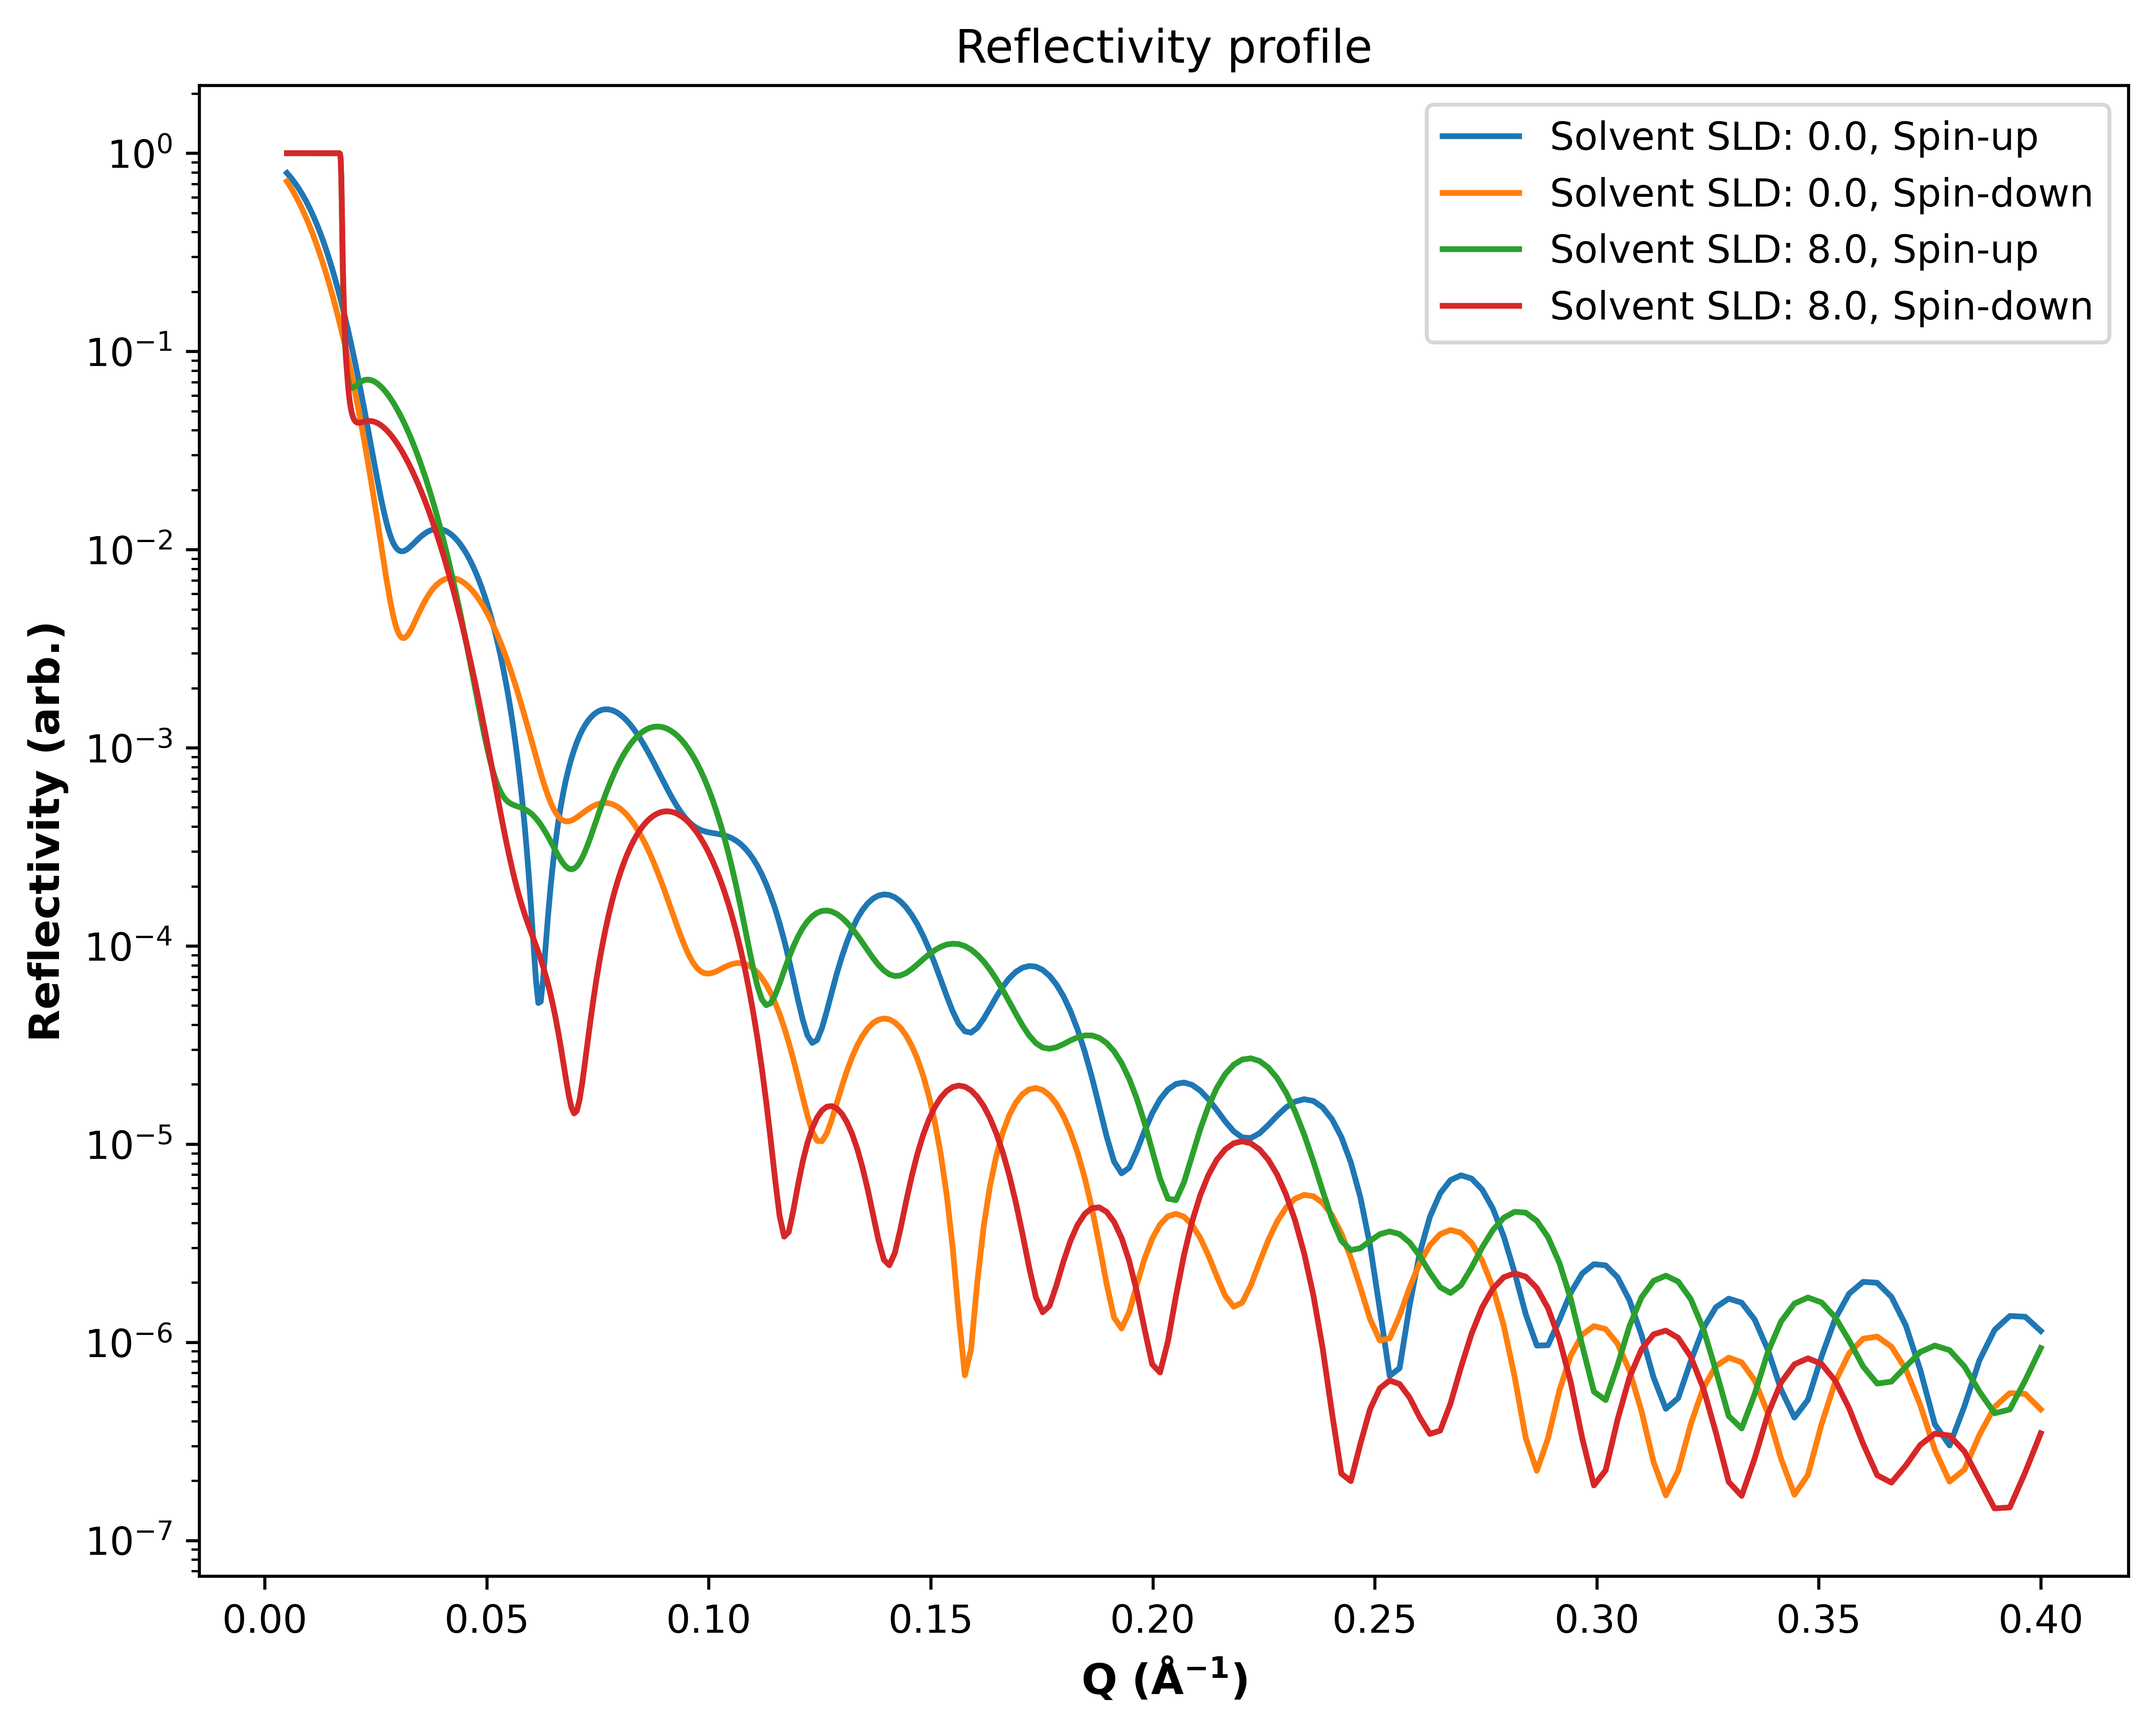

In [12]:
optimise_parameters(sample, angle_times)


## Optimizing for solvent

We can also optimize for a list of measurements at once. One typical example is when the same sample is measured twice in different solvents. In this case we can describe one structure for each measurement, and then optimize to the solvent SLD. When defining multiple measurements, the sample can be put in a list of structures.

In this example, we imagine we have a structure consisting of three different layers on the substrate, measured in a certain solvent. We want to optimize the solvent SLD, such that we get most information possible about the SLD of each layer, the volume fraction of the solvent, and the structural properties of each layer. 

In [ ]:
def solvent_sample():
    """Define a bilayer sample, and return the associated refnx model"""
    
    # Define the fitting parameters for the sample:   
    layer1_thick = Parameter(15, 'Layer 1 Thickness', (10, 25))
    layer2_thick = Parameter(28, 'Layer 2 Thickness', (20, 40))
    layer3_thick = Parameter(16, 'Layer 3 Thickness', (10, 25))    
    layer1_rough = Parameter(4, 'Layer 1 Roughness', (2, 10))
    layer2_rough = Parameter(3, 'Layer 2 Roughness', (2, 10))
    layer3_rough = Parameter(3, 'Layer 3 Roughness', (50, 120))
    layer1_sld = Parameter(2.7, 'Layer 1 SLD', (1, 4))
    layer2_sld = Parameter(0.1, 'Layer 1 SLD', (-0.5, 2))
    layer3_sld = Parameter(3.0, 'Layer 1 SLD', (-1, 4))    
    vfsolv1 = Parameter(0.5, 'Layer 1 volume solvent fraction', (0.4, 0.8))
    vfsolv2 = Parameter(0.08, 'Layer 2 volume solvent fraction', (0.0, 0.8))
    vfsolv3 = Parameter(0.82, 'Layer 3 volume solvent fraction', (0.6, 0.9))

    
    # Define the parameters for two different solvents, we allow this to vary between 
    # the SLD for H2O and D2O
    solvent1_sld = Parameter(6.19, 'Solvent 1 SLD', (-0.52, 6.19))
    solvent2_sld = Parameter(-0.5227, 'Solvent 2 SLD', (-0.52, 6.19))    
    
    # Tell HOGBEN that these parameters should be optimized
    solvent2_sld.optimize = True
    
    # Construct the layers
    solvent1 = SLD(solvent1_sld, name='Solvent 1')(rough=3)
    solvent2 = SLD(solvent2_sld, name='Solvent 2')(rough=3)    
    layer1 = SLD(layer1_sld, name="Layer 1")(thick=layer1_thick, rough=layer1_rough, vfsolv=vfsolv1)
    layer2 = SLD(layer2_sld, name="Layer 2")(thick=layer2_thick, rough=layer2_rough, vfsolv=vfsolv2)
    layer3 = SLD(layer3_sld, name="Layer 3")(thick=layer3_thick, rough=layer3_rough, vfsolv=vfsolv3)
    substrate = SLD(2.074, name='Substrate')(rough=3)

    # Put all fitting parameters in a list
    params = [
        vfsolv1,
        vfsolv2,
        vfsolv3,
        layer1_sld,
        layer2_sld,
        layer3_sld,
    ]
    
    # Set all fitting parameters to be varying
    for param in params:
        param.vary = True
    
    # Create a structure, separating each layer with a `|`
    sample1 = substrate | layer1 | layer2 | layer3 | solvent1
    sample2 = substrate | layer1 | layer2 | layer3 | solvent2
    
    return [sample1, sample2]

Now just as we did previously, we simply put the above structure in a HOGBEN sample using `Sample`. Then we need to define the `angle_times` object and tell HOGBEN to optimise the parameters.

In [ ]:
structures = solvent_sample()
sample = Sample(structures)
angle_times = [(0.7, 100, 100),
               (2.3, 100, 400),
               ]    
optimise_parameters(sample, angle_times)


## Optimising to both solvent and a reference layer

We can combine any arbitrary set of parameters for the optimization. To add a reference layer, we would thus simply need to add another layer to the sample, and optimize for its properties. In this example, we assume the sample is measured in H2O twice, and want to determine what the best reference layer would be, and in what contrast we should measure for the second measurement.

In [ ]:
def solvent_ref_layer():
    """Define a bilayer sample, and return the associated refnx model"""
    
    # Define the fitting parameters for the sample:   
    layer1_thick = Parameter(15, 'Layer 1 Thickness', (10, 25))
    layer2_thick = Parameter(28, 'Layer 2 Thickness', (20, 40))
    layer3_thick = Parameter(16, 'Layer 3 Thickness', (10, 25))    
    layer1_rough = Parameter(4, 'Layer 1 Roughness', (2, 10))
    layer2_rough = Parameter(3, 'Layer 2 Roughness', (2, 10))
    layer3_rough = Parameter(3, 'Layer 3 Roughness', (50, 120))
    layer1_sld = Parameter(2.7, 'Layer 1 SLD', (1, 4))
    layer2_sld = Parameter(0.1, 'Layer 1 SLD', (-0.5, 2))
    layer3_sld = Parameter(3.0, 'Layer 1 SLD', (-1, 4))    
    vfsolv1 = Parameter(0.5, 'Layer 1 volume solvent fraction', (0.4, 0.8))
    vfsolv2 = Parameter(0.08, 'Layer 2 volume solvent fraction', (0.0, 0.8))
    vfsolv3 = Parameter(0.82, 'Layer 3 volume solvent fraction', (0.6, 0.9))

    
    # Define the parameters for the reference layer that we want to optimize
    solvent1_sld = Parameter(6.19, 'Solvent 1 SLD', (-0.52, 6.19))
    solvent2_sld = Parameter(-0.5227, 'Solvent 2 SLD', (-0.52, 6.19))    
    ref_thick = Parameter(50, 'Reference layer Thickness', (0, 400))
    ref_sld = Parameter(2, 'Reference layer SLD', (-1.9, 9.4))
    
    # Tell HOGBEN that these parameters should be optimized
    ref_thick.optimize = True
    ref_sld.optimize = True
    solvent1_sld.optimize = True
    
    # Construct the layers
    solvent1 = SLD(solvent1_sld, name='Solvent 1')(rough=3)
    solvent2 = SLD(solvent2_sld, name='Solvent 2')(rough=3)    
    layer1 = SLD(layer1_sld, name="Layer 1")(thick=layer1_thick, rough=layer1_rough, vfsolv=vfsolv1)
    layer2 = SLD(layer2_sld, name="Layer 2")(thick=layer2_thick, rough=layer2_rough, vfsolv=vfsolv2)
    layer3 = SLD(layer3_sld, name="Layer 3")(thick=layer3_thick, rough=layer3_rough, vfsolv=vfsolv3)
    ref_layer = SLD(ref_sld, name="Reference Layer")(thick=ref_thick, rough=3)    
    substrate = SLD(2.074, name='Substrate')(rough=3)

    # Put all fitting parameters in a list
    params = [
        vfsolv1,
        vfsolv2,
        vfsolv3,
        layer1_sld,
        layer2_sld,
        layer3_sld,
    ]
    
    # Set all fitting parameters to be varying
    for param in params:
        param.vary = True
    
    # Create a structure, separating each layer with a `|`
    sample1 = substrate | ref_layer | layer1 | layer2 | layer3 | solvent1
    sample2 = substrate | ref_layer | layer1 | layer2 | layer3 | solvent2
    
    return [sample1, sample2]

Now just as we did previously, we simply put the above structure in a HOGBEN sample using `Sample`. Then we need to define the `angle_times` object and tell HOGBEN to optimise the parameters.


In [ ]:
structures = solvent_ref_layer()
sample = Sample(structures)
angle_times = [(0.7, 100, 100),
               (2.3, 100, 400),
               ]    
optimise_parameters(sample, angle_times)
